In [136]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [71]:
plt.rcParams.update({
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.linewidth': 0.5,
    'xtick.major.size': 2,
    'ytick.major.size': 2,
    'xtick.minor.size': 1,
    'ytick.minor.size': 1,
    'xtick.labelsize': 8,       # 8 point font size
    'ytick.labelsize': 8,       # 8 point font size
    'grid.alpha': 0.3,
})

## Eliciting datasets and using date/time columns as index for Time Series Analysis.

In [72]:
Johnson = pd.read_csv('./Data/jj.csv')
Johnson['date'] = pd.to_datetime(Johnson['date'])
Johnson.set_index('date', inplace=True)
Johnson.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [73]:
Amazon = pd.read_csv('./Data/AMZN.csv')
Amazon['Date'] = pd.to_datetime(Amazon['Date'])
Amazon.set_index('Date', inplace=True)
Amazon.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


Plotting target variables for both datasets.

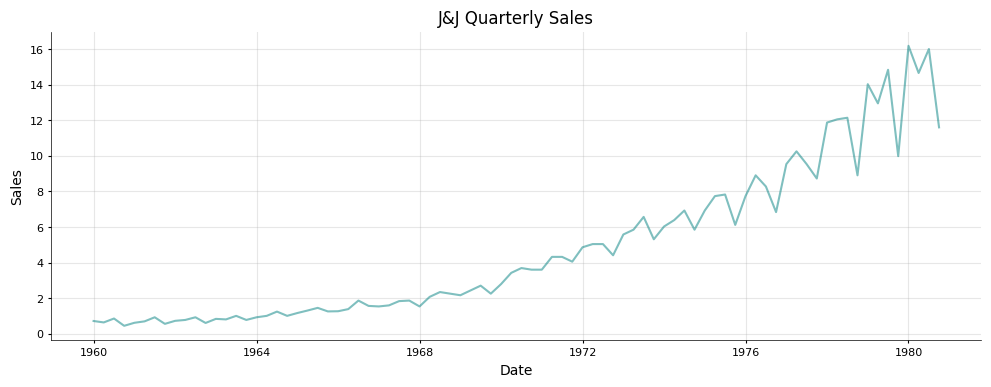

In [74]:
plt.figure(figsize=(12, 4))
plt.plot(Johnson['data'], color='teal', alpha=0.5)
plt.title('J&J Quarterly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


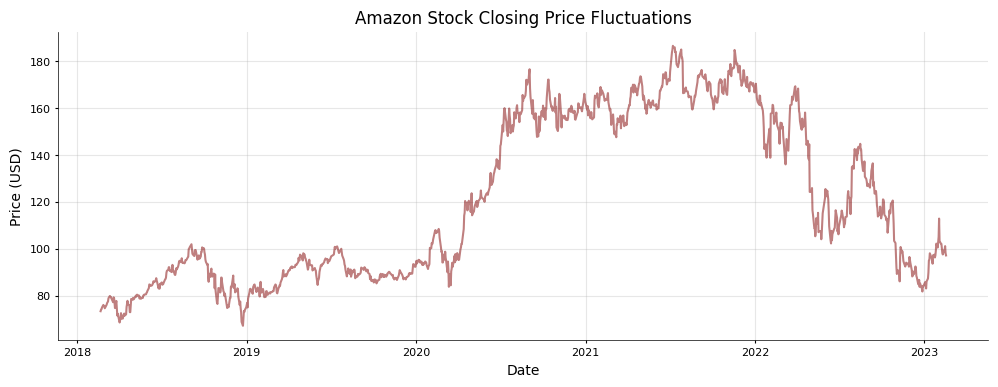

In [75]:
plt.figure(figsize=(12, 4))
plt.plot(Amazon['Close'], color='Maroon', alpha=0.5)
plt.title('Amazon Stock Closing Price Fluctuations')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

## Investigating properties of the datasets.

#### Johnson & Johnson

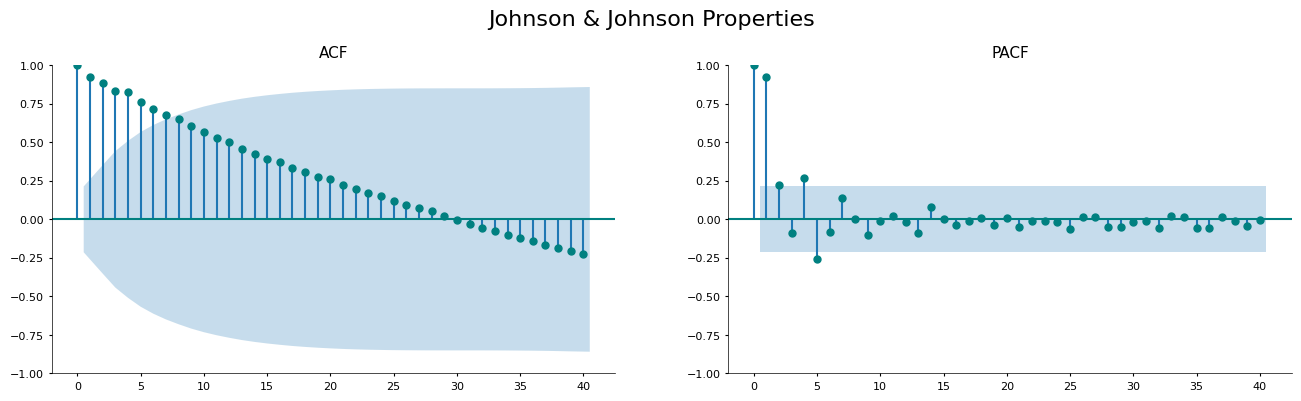

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(Johnson['data'], lags=40, ax=ax[0], color='Teal')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(Johnson['data'], lags=40, ax=ax[1], color='Teal')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('Johnson & Johnson Properties', fontsize=16, y=1.02)
plt.show()

In [77]:
# Defining a function for ADF Testing.
def AdfTester(series, name=''):
    """
    Parameters:
    series : Time series data.
    name : to print a name of the set undergoing ADF.
    """

    AdfResult = adfuller(series.squeeze())

    print(f'---ADF Test Results for {name}---')
    print(f'ADF Statistic: {AdfResult[0]: .3f}')
    print(f'P-Value: {AdfResult[1]: .3f}')

    for key, value in AdfResult[4].items():
        print(f'Critical Value ({key}): {value: .3f}')

In [78]:
AdfTester(Johnson['data'], 'Johnson & Johnson Data')

---ADF Test Results for Johnson & Johnson Data---
ADF Statistic:  2.742
P-Value:  1.000
Critical Value (1%): -3.525
Critical Value (5%): -2.903
Critical Value (10%): -2.589


Non-stationary is observed in data as the 5% critical is less than ADF Statistic with a P-Value greater that 0.05, applying log & first order differencing.

In [79]:
JohnsonLog = np.log(Johnson + 1e-10) # Adding a small constant to avoid log(0)

In [80]:
JohnsonLogFODiff = JohnsonLog.diff().dropna()
AdfTester(JohnsonLogFODiff.squeeze(), 'J&J with First Order Differencing')

---ADF Test Results for J&J with First Order Differencing---
ADF Statistic: -4.317
P-Value:  0.000
Critical Value (1%): -3.518
Critical Value (5%): -2.900
Critical Value (10%): -2.587


Stationarity acquired after 1st order differencing, visualized as below.

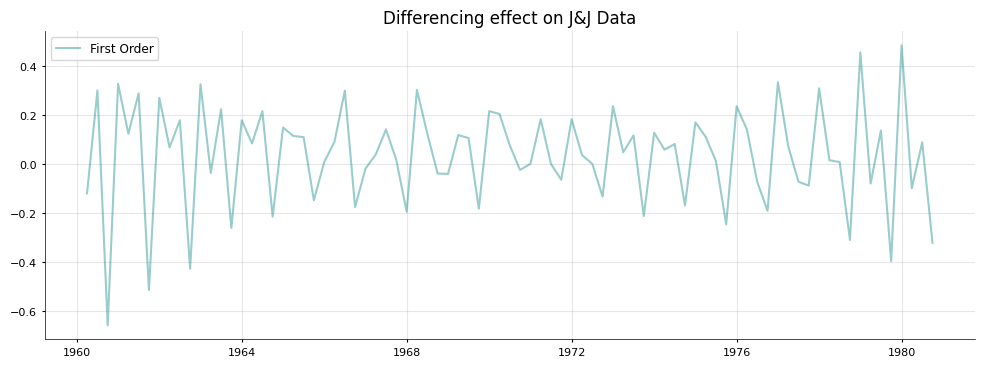

In [81]:
plt.figure(figsize=(12, 4))
plt.plot(JohnsonLogFODiff['data'], label='First Order', alpha=0.4, color='Teal')
plt.title('Differencing effect on J&J Data')
plt.legend(fontsize=8.75)
plt.grid(True)
plt.show()

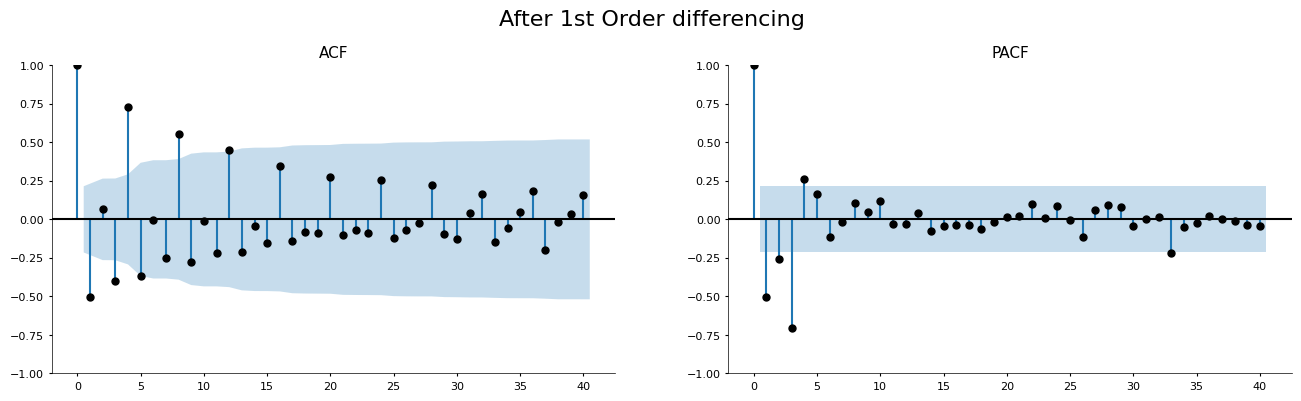

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(JohnsonLogFODiff['data'], lags=40, ax=ax[0], color='Black')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(JohnsonLogFODiff['data'], lags=40, ax=ax[1], color='Black')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('After 1st Order differencing', fontsize=16, y=1.02)
plt.show()

Applying boxcox to compare Log & Boxcox Transformation in handling non-stationarity.

In [83]:
JohnsonBC, lambda_ = boxcox(Johnson['data'] + 1 - Johnson['data'].min())

In [84]:
JohnsonBCFODiff = np.diff(JohnsonBC)
AdfTester(JohnsonBCFODiff.squeeze(), 'J&J with First Order Differencing')

---ADF Test Results for J&J with First Order Differencing---
ADF Statistic: -2.889
P-Value:  0.047
Critical Value (1%): -3.521
Critical Value (5%): -2.901
Critical Value (10%): -2.588


Stationarity Achieved after 1st order differencing, visualized as below.

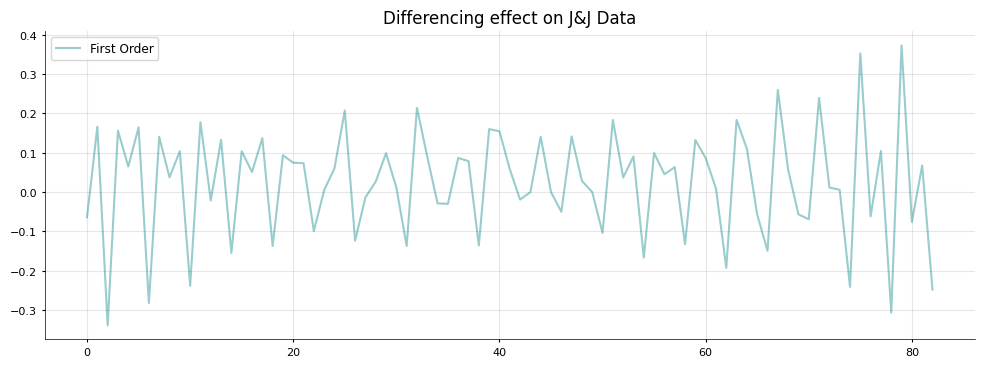

In [85]:
plt.figure(figsize=(12, 4))
plt.plot(JohnsonBCFODiff, label='First Order', alpha=0.4, color='Teal')
plt.title('Differencing effect on J&J Data')
plt.legend(fontsize=8.75)
plt.grid(True)
plt.show()

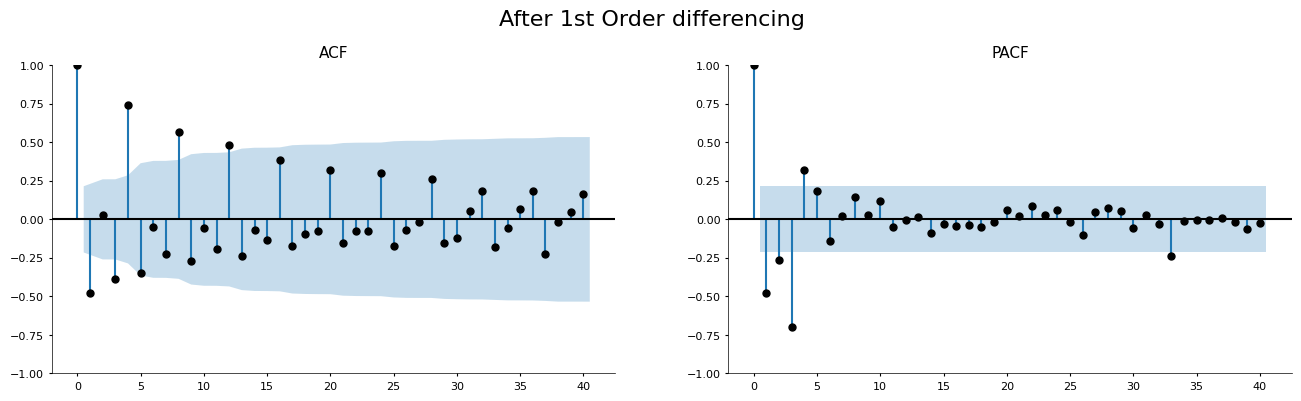

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(JohnsonBCFODiff, lags=40, ax=ax[0], color='Black')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(JohnsonBCFODiff, lags=40, ax=ax[1], color='Black')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('After 1st Order differencing', fontsize=16, y=1.02)
plt.show()

Log Transformed data acquires stationarity after first order differencing so we'll move forward with that.

#### Amazon

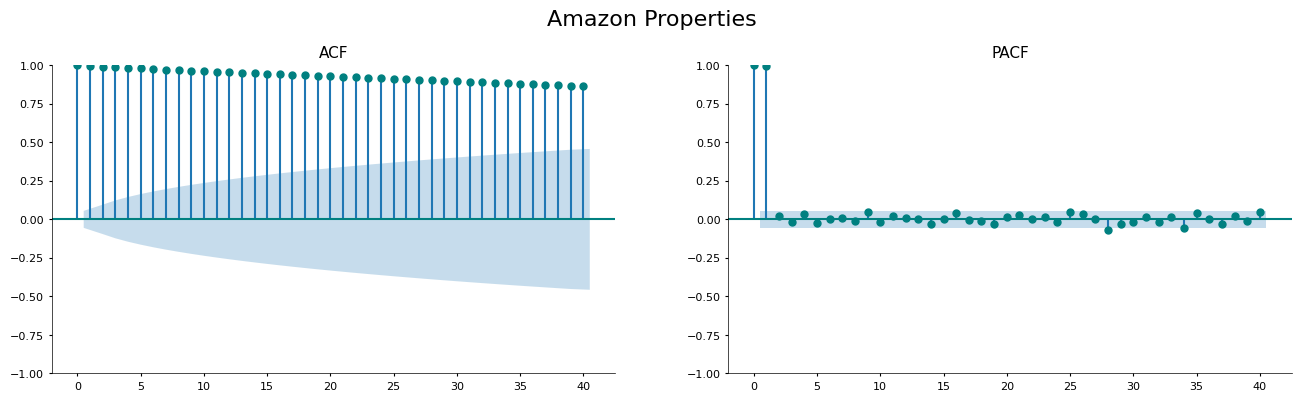

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(Amazon['Close'], lags=40, ax=ax[0], color='Teal')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(Amazon['Close'], lags=40, ax=ax[1], color='Teal')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('Amazon Properties', fontsize=16, y=1.02)
plt.show()

In [88]:
AdfTester(Amazon['Close'], 'Amazon Data')

---ADF Test Results for Amazon Data---
ADF Statistic: -1.658
P-Value:  0.453
Critical Value (1%): -3.436
Critical Value (5%): -2.864
Critical Value (10%): -2.568


Differencing is required as P-Value is higher than 0.05 & critical value at 5% (-2.864) is also less than ADF Statistic (-1.658). 

In [89]:
AmazonLog = np.log(Amazon['Close'] + 1e-10) # Adding a small constant to avoid log(0)

In [90]:
AmazonFODiff = AmazonLog.diff().dropna()
AdfTester(AmazonFODiff, 'Amazon (After 1st Order Difference)')

---ADF Test Results for Amazon (After 1st Order Difference)---
ADF Statistic: -36.640
P-Value:  0.000
Critical Value (1%): -3.436
Critical Value (5%): -2.864
Critical Value (10%): -2.568


Stationarity acquired after first order differencing, Visualized as below.

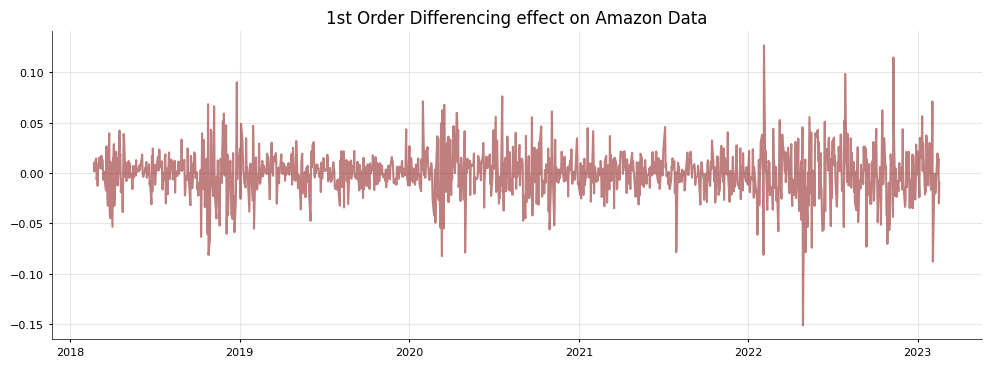

In [91]:
plt.figure(figsize=(12, 4))
plt.plot(AmazonFODiff, label='First Order', alpha=0.5, color='Maroon')
plt.title('1st Order Differencing effect on Amazon Data')
plt.grid(True)
plt.show()

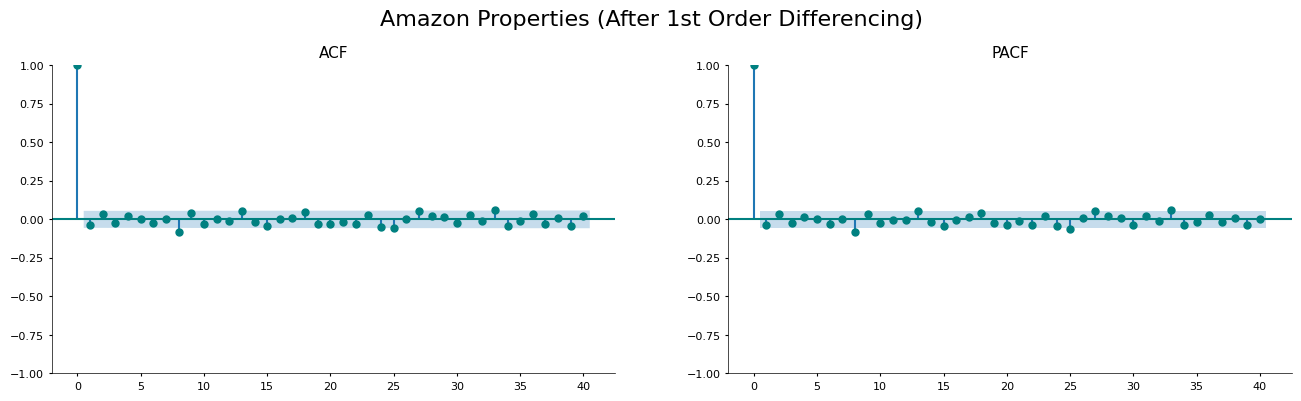

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

# Plotting Autocorrelation and Partial autocorrelation.
plot_acf(AmazonFODiff, lags=40, ax=ax[0], color='Teal')
ax[0].set_title('ACF', fontsize=11)
plot_pacf(AmazonFODiff, lags=40, ax=ax[1], color='Teal')
ax[1].set_title('PACF', fontsize=11)
plt.suptitle('Amazon Properties (After 1st Order Differencing)', fontsize=16, y=1.02)
plt.show()

## Training ARMA models with transformed data.

#### Manual Approach

In [103]:
from tqdm import tqdm
def ManArimaBP(TrainData, MaxP=12, MaxD=1, MaxQ=12):
    """
    Grid search over p, d & q to find the best fit with lowest AIC.
    """

    BestAIC = np.inf
    BestOrder = None
    Results = []

    # Generating all possible combinations for p,d & q.
    pdq = list(product(range(0, MaxP+1), 
                       range(0,MaxD+1), 
                       range(0,MaxQ+1)))
    
    # Removing (0, 0, 0) corresponding to white noise.
    pdq = [order for order in pdq if order != (0, 0, 0)]

    with warnings.catch_warnings():
        for order in tqdm(pdq):
            try:
                Model = ARIMA(TrainData.dropna(), order=order)
                ModelFit = Model.fit()
                Aic = ModelFit.aic
                Results.append({'Order': order,'AIC': Aic})
                if Aic < BestAIC:
                    BestAIC = Aic
                    BestOrder = order
            except:
                continue # To skip combinations that cause invalidity.
    
    ResultantDF = pd.DataFrame(Results).sort_values('AIC')
    return BestOrder, BestAIC, ResultantDF


In [115]:
BestOrderJJ, BestAIC, ResultDF = ManArimaBP(Johnson)
print(f'Best ARIMA Order (Johnson & Johnson): {BestOrderJJ} | AIC: {BestAIC}')

100%|██████████| 337/337 [04:34<00:00,  1.23it/s]

Best ARIMA Order (Johnson & Johnson): (5, 0, 2) | AIC: 18.0


In [116]:
BestOrderAMZN, BestAIC_A, ResultDF_A = ManArimaBP(Amazon['Close'])
print(f'Best ARIMA Order (Amazon): {BestOrderAMZN} | AIC: {BestAIC_A}')

100%|██████████| 337/337 [16:16<00:00,  2.90s/it]

Best ARIMA Order (Amazon): (2, 1, 2) | AIC: 6122.315475725398


#### Automated Approach

Unable to complete milestone, dependency error as below.

from pmdarima import auto_arima

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[27], line 1
----> 1 from pmdarima import auto_arima

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\__init__.py:52
     49 from . import __check_build
     51 # Stuff we want at top-level
---> 52 from .arima import auto_arima, ARIMA, AutoARIMA, StepwiseContext, decompose
     53 from .utils import acf, autocorr_plot, c, pacf, plot_acf, plot_pacf, \
     54     tsdisplay
     55 from .utils._show_versions import show_versions

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\__init__.py:5
      1 # -*- coding: utf-8 -*-
      2 #
      3 # Author: Taylor Smith <taylor.smith@alkaline-ml.com>
----> 5 from .approx import *
      6 from .arima import *
      7 from .auto import *

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\approx.py:9
      1 # -*- coding: utf-8 -*-
      2 #
      3 # Author: Taylor Smith <taylor.smith@alkaline-ml.com>
      4 #
      5 # R approx function
      7 import numpy as np
----> 9 from ..utils.array import c, check_endog
     10 from ..utils import get_callable
     11 from ..compat.numpy import DTYPE

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\utils\__init__.py:5
      1 # -*- coding: utf-8 -*-
      2 #
      3 # Author: Taylor Smith <taylor.smith@alkaline-ml.com>
----> 5 from .array import *
      6 from .metaestimators import *
      7 from .visualization import *

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\utils\array.py:13
     10 import pandas as pd
     12 from ..compat import DTYPE
---> 13 from ._array import C_intgrt_vec
     15 __all__ = [
     16     'as_series',
     17     'c',
   (...)
     22     'is_iterable'
     23 ]
     26 def as_series(x, **kwargs):

File c:\Users\us392\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\utils\_array.pyx:1, in init pmdarima.utils._array()

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# Hypothetical methodology implemented as below.

# def AutoArimaBP(TrainData, seasonal=False, MaxP=12, MaxD=1, MaxQ=8):
#     """
#     Automatically find best ARIMA model using pmdarima.
#     """

#     Model = auto_arima(
#         TrainData,
#         seasonal=seasonal,
#         max_p=MaxP,
#         max_d=MaxD,
#         max_q=MaxQ,
#         error_action='ignore',
#         suppress_warnings=True,
#         stepwise=True,
#         information_criterion='aic',
#         trace=True
#     )

#     return Model

# AutoModel = AutoArimaBP(Johnson, seasonal=False)
# print(AutoModel.summary())

Using best parameters (available) to train model for forecasting.

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -133.926
Date:                Thu, 10 Apr 2025   AIC                            275.851
Time:                        23:28:00   BIC                            285.574
Sample:                             0   HQIC                           279.760
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8140      6.061      1.124      0.261      -5.066      18.694
ar.L1          0.9966      0.021     48.246      0.000       0.956       1.037
ma.L1         -0.5708      0.112     -5.086      0.0

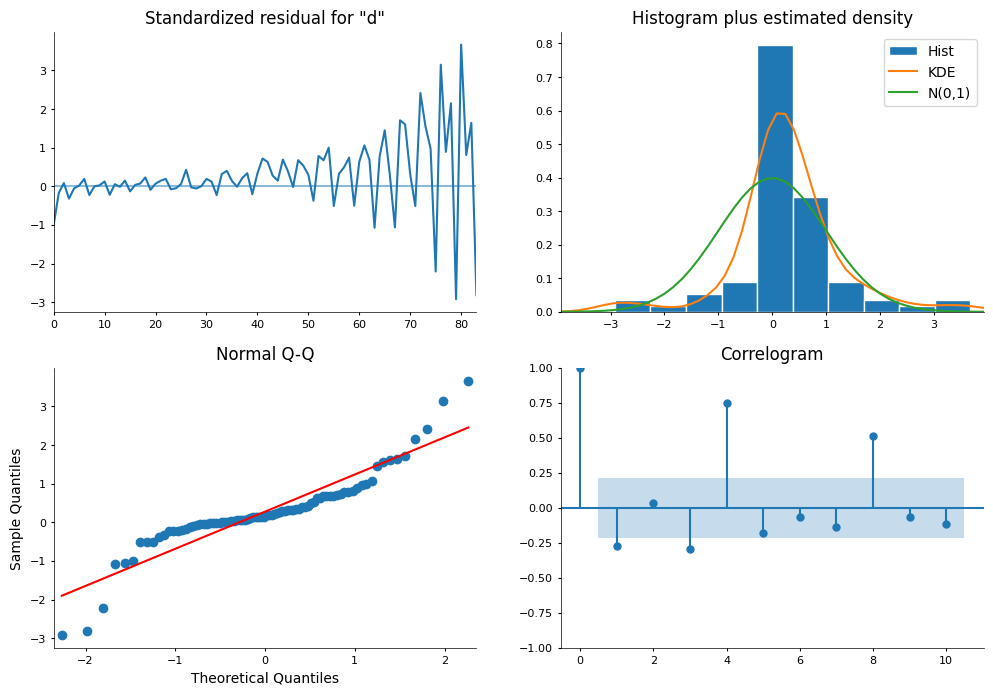

In [123]:
ArimaModelJJ = ARIMA(Johnson, order=BestOrderJJ)
ArimaFitJJ = ArimaModelJJ.fit()

print(ArimaFitJJ.summary())


residuals = ArimaFitJJ.resid + np.random.normal(0, 1e-6, len(ArimaFitJJ.resid))
ArimaFitJJ.model.data.endog = ArimaFitJJ.model.data.endog + residuals
ArimaFitJJ.plot_diagnostics(figsize=(12, 8))  # Force KDE to work

plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3068.192
Date:                Thu, 10 Apr 2025   AIC                           6142.384
Time:                        22:59:36   BIC                           6157.798
Sample:                             0   HQIC                          6148.177
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.7719     23.293      4.670      0.000      63.119     154.424
ar.L1          0.9969      0.002    428.488      0.000       0.992       1.001
sigma2         7.6301      0.156     49.045      0.0

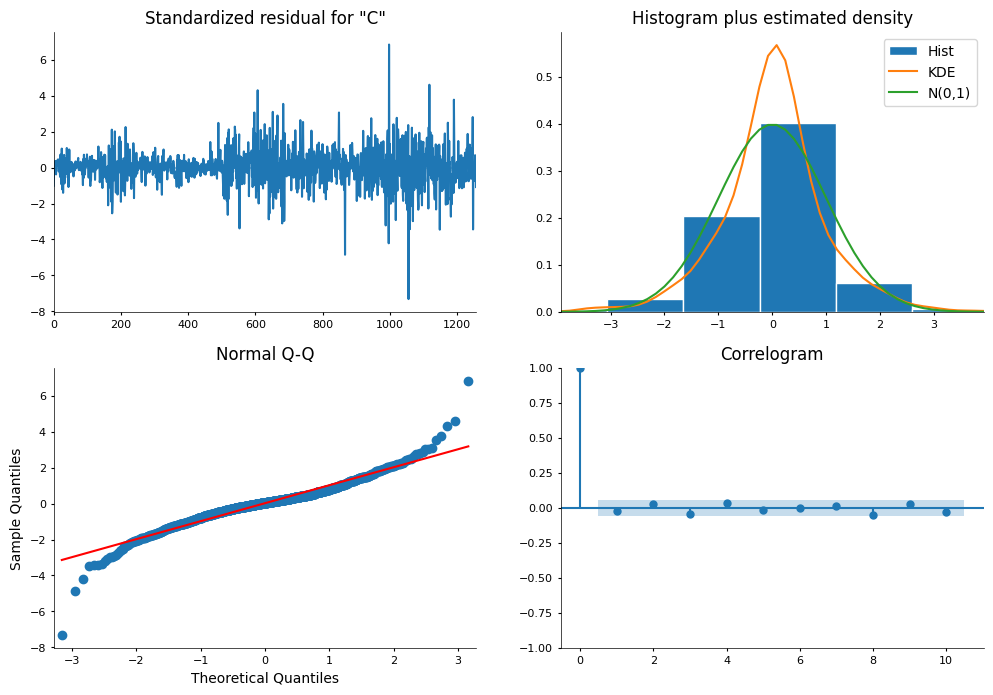

In [ ]:
ArimaModelAMZN = ARIMA(Amazon['Close'], order=BestOrderAMZN)
ArimaFitAMZN = ArimaModelAMZN.fit()

print(ArimaFitAMZN.summary())

ArimaFitAMZN.plot_diagnostics(figsize=(12, 8))
plt.show()

## Generating forecast using Selected ARIMA

Johnson & Johnson

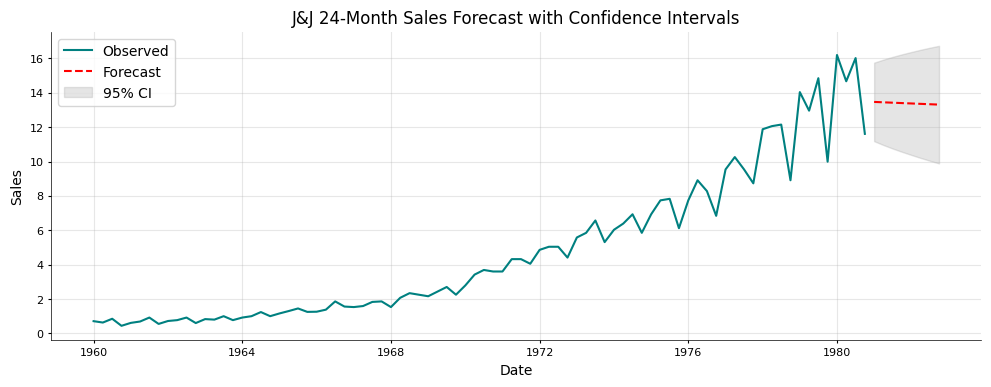

Forecasted Values: 
84    13.469029
85    13.446400
86    13.423848
87    13.401372
88    13.378973
89    13.356650
90    13.334403
91    13.312232
Name: predicted_mean, dtype: float64

Confidence Intervals: 
    lower data  upper data
84   11.184208   15.753851
85   10.963119   15.929681
86   10.758040   16.089656
87   10.565882   16.236862
88   10.384456   16.373491
89   10.212136   16.501165
90   10.047679   16.621128
91    9.890108   16.734356


In [124]:
JohnsonSeries = Johnson['data']

# 24 months = 8 Quarters.
ForecastLength = 8

Forecast = ArimaFitJJ.get_forecast(steps=ForecastLength)
ForecastMean = Forecast.predicted_mean
ConfidenceInterval = Forecast.conf_int()

# Extending indices to generate forecast.
ForecastIndex = pd.date_range(
    start=JohnsonSeries.index[-1] + pd.offsets.QuarterEnd(),
    periods=ForecastLength,
    freq='Q'
) 


plt.figure(figsize=(12, 4))
plt.plot(Johnson, label='Observed', color='Teal')
plt.plot(ForecastIndex, ForecastMean,
         label='Forecast', color='red', linestyle='--')

plt.fill_between(ForecastIndex,
                 ConfidenceInterval.iloc[:, 0],
                 ConfidenceInterval.iloc[:, 1],
                 color='grey', alpha=0.2, label='95% CI')

plt.title('J&J 24-Month Sales Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

print('Forecasted Values: ')
print(ForecastMean)
print('\nConfidence Intervals: ')
print(ConfidenceInterval)

Amazon

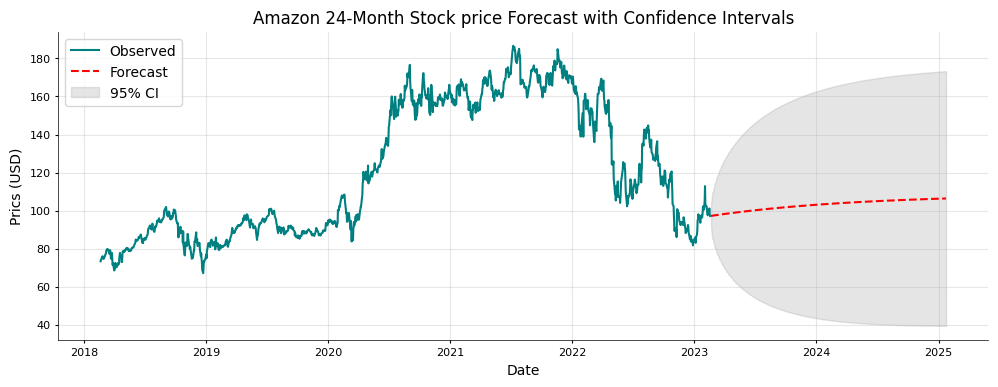

Forecasted Values: 
1259     97.236416
1260     97.272721
1261     97.308912
1262     97.344988
1263     97.380951
           ...    
1758    106.379057
1759    106.386588
1760    106.394095
1761    106.401579
1762    106.409039
Name: predicted_mean, Length: 504, dtype: float64

Confidence Intervals: 
      lower Close  upper Close
1259    91.822481   102.650351
1260    89.628299   104.917143
1261    87.961151   106.656672
1262    86.568060   108.121916
1263    85.350865   109.411037
...           ...          ...
1758    39.561987   173.196127
1759    39.560140   173.213035
1760    39.558330   173.229860
1761    39.556556   173.246602
1762    39.554817   173.263260

[504 rows x 2 columns]


In [ ]:
AmazonSeries = Amazon['Close']

# 24 months = 8 Quarters.
ForecastLength = 504

Forecast = ArimaFitAMZN.get_forecast(steps=ForecastLength)
ForecastMean = Forecast.predicted_mean
ConfidenceInterval = Forecast.conf_int()

# Extending indices to generate forecast.
ForecastIndex = pd.date_range(
    start=AmazonSeries.index[-1] + pd.Timedelta(days=1),
    periods=ForecastLength,
    freq='B'
) 


plt.figure(figsize=(12, 4))
plt.plot(AmazonSeries, label='Observed', color='Teal')
plt.plot(ForecastIndex, ForecastMean,
         label='Forecast', color='red', linestyle='--')

plt.fill_between(ForecastIndex,
                 ConfidenceInterval.iloc[:, 0],
                 ConfidenceInterval.iloc[:, 1],
                 color='grey', alpha=0.2, label='95% CI')

plt.title('Amazon 24-Month Stock price Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Prics (USD)')
plt.legend()
plt.grid(True)
plt.show()

print('Forecasted Values: ')
print(ForecastMean)
print('\nConfidence Intervals: ')
print(ConfidenceInterval)

## Employing LSTM & GRU

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

def SequenceGen(Data, Window):
    X, y = [], []

    for i in range(len(Data) - Window):
        X.append(Data[i:i+Window])
        y.append(Data[i+Window])
    
    return np.array(X), np.array(y)

In [175]:
def BuildLSTM(InputShape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=InputShape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

Window = 12
epochs = 50
BatchSize = 16

JohnsonData = Johnson['data'].values.reshape(-1, 1)
ScalerJohnson = MinMaxScaler()
JohnsonScaled = ScalerJohnson.fit_transform(JohnsonData)

JohnsonX, JohnsonY = SequenceGen(JohnsonScaled, Window)

JohnsonX = JohnsonX.reshape((JohnsonX.shape[0],
                             JohnsonX.shape[1], 1))

JohnsonLSTM = BuildLSTM(JohnsonX.shape[1:])
JohnsonHistory = JohnsonLSTM.fit(JohnsonX, JohnsonY,
                                 epochs=epochs,
                                 batch_size=BatchSize)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1320 - mae: 0.2634
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0456 - mae: 0.1572
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0181 - mae: 0.1218
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0143 - mae: 0.1084
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0729 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - mae: 0.0656 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - mae: 0.0488
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0051 - mae: 0.0456
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0412 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049 - mae: 0.0494
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0050 - mae: 0.0485
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0058 - mae: 0.0459
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


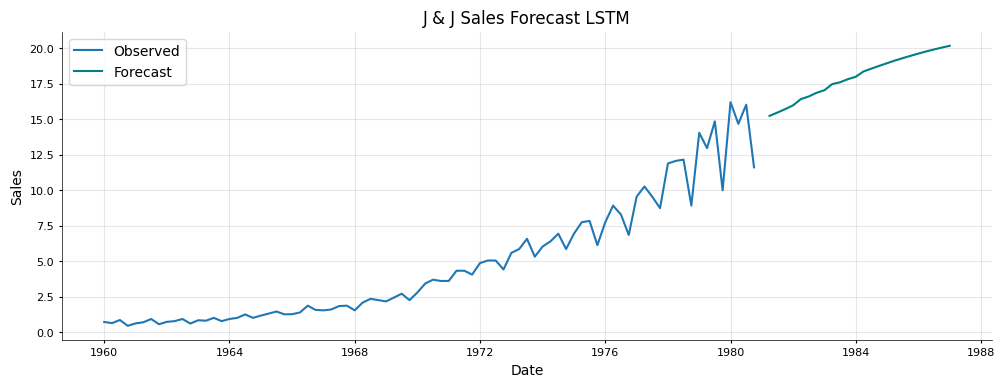

In [176]:
ForecastJ = list(JohnsonScaled[-Window:])
PredsJ = []

for _ in range(24):
    InputSequence = np.array(ForecastJ[-Window:]).reshape(1, Window, 1)
    Preds = JohnsonLSTM.predict(InputSequence)
    PredsJ.append(Preds[0][0])
    ForecastJ.append(Preds[0])

ForecastJInverse = ScalerJohnson.inverse_transform(np.array(PredsJ).reshape(-1, 1))

JohnsonForecastIndex = pd.date_range(start=Johnson.index[-1],
                                     periods=25,
                                     freq='QE')[1:]

plt.figure(figsize=(12, 4))
plt.plot(Johnson['data'], label='Observed')
plt.plot(JohnsonForecastIndex, ForecastJInverse,
         label='Forecast', color='Teal')
plt.title('J & J Sales Forecast LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
def BuildGRU(InputShape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=InputShape))
    model.add(GRU(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


AmznData = Amazon['Close'].values.reshape(-1, 1)
ScalerAmzn = MinMaxScaler()
AmznScaled = ScalerAmzn.fit_transform(AmznData)

AmznX, AmznY = SequenceGen(AmznScaled, Window)
AmznX = AmznX.reshape((AmznX.shape[0], AmznX.shape[1], 1))

AmazonGRU = BuildGRU(AmznX.shape[1:])
AmazonGRU.fit(AmznX, AmznY,
              epochs=epochs,
              batch_size=BatchSize)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0574 - mae: 0.1560
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - mae: 0.0259
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - mae: 0.0247
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - mae: 0.0253
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4511e-04 - mae: 0.0223
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4135e-04 - mae: 0.0222
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.3386e-04 - mae: 0.0214
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1007e-04 - mae: 0.0227
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.5858e-04 - mae: 0.0201
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.1896e-04 - mae: 0.0193
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.3254e-04 - mae: 0.0199
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5259e-04 - mae: 0.0186
Epoch 13/50
78/78

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

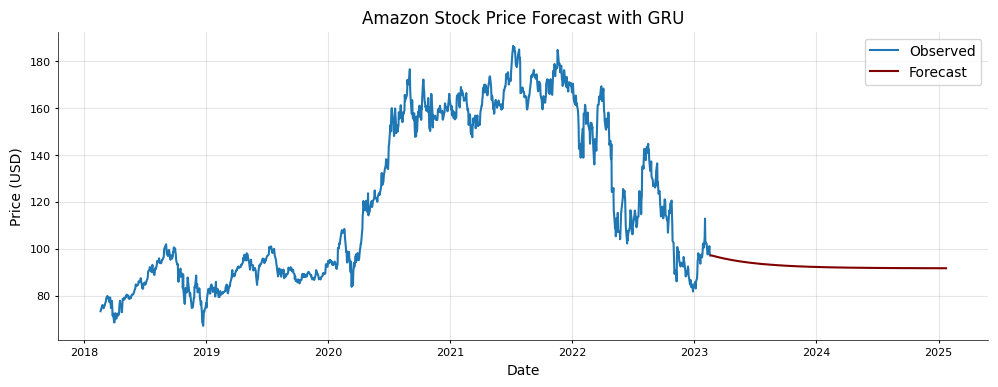

In [178]:
ForecastA = list(AmznScaled[-Window:])
PredsA = []

for _ in range(504):
    InputSequence = np.array(ForecastA[-Window:]).reshape(1, Window, 1)
    Preds = AmazonGRU.predict(InputSequence)
    PredsA.append(Preds[0][0])
    ForecastA.append(Preds[0])

ForecastAInverse = ScalerAmzn.inverse_transform(
    np.array(PredsA).reshape(-1, 1))

AmznForecastIndex = pd.date_range(
    start=Amazon.index[-1],
    periods=505,
    freq='B'
)[1:]
plt.figure(figsize=(12, 4))
plt.plot(Amazon['Close'], label='Observed')
plt.plot(AmznForecastIndex, ForecastAInverse,
         label='Forecast', color='Maroon')
plt.title('Amazon Stock Price Forecast with GRU')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()